# Phase 3 project - Predicting Covid Hospitalizations

Student name: Maria Kuzmin
Student pace: Flex
Scheduled project review date/time: Tuesday, Jan 17th
Instructor name: Morgan Jones



## Introduction


During the covid 19 pandemic one of the major issues in the healthcare system was the shortage of medical resources and the lack of a system to distribute them according to the local hospitals and facilities’ needs.

In this project we analized a dataset with information about patients haealth conditions and medical history, and tried to predict whether the patient is in high risk or not for needing to be hospitalized due to Covid-19 infection.
We focused only on the patients that tested positive for covid-19, and studied as the target whether or not the patient was admitted into the hospital, or sent home to continue treatment independently.

Being able to predict such information could help to estimate the amount of people that will require hospitalization for the next pandemic. This would help the authorities getting ready to be able to procure and arrange for the resources necessary to treat all the patients in need. 
Based on such model we were also able to look at the most crucial factors that determined the outcome, to identify what are the conditions that ultimately put a patient at risk, to help the healthcare system target those factors specifically.

### The Goal:
The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current health condition, and medical history, will predict whether the patient is in high risk or not for needing to be hospitalized due to Covid-19 infection.
Investigating more in depth the best performing models, we will also analyze what are the factors that are most influetial in determining wheter a patient is at risk or not.

### The Stakeholders: the CDC

Analyzing the medical conditions of patients in a certain area or county could help the CDC and hospitals predict the amount of patients they should expect to hospitalize, and therefore being prepared and properly equipped to treat them.
Looking at the most determining factors for high-risk in patients, the CDC could also direct more specific effort to treat and prevent such conditions, launching health campaigns and alerting healthcare providers about those conditions.

### Imports

Let us import all the libraries and tool that we are going to need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier

from colorama import Fore
from colorama import Style

import warnings
warnings.filterwarnings('ignore')

##  The Covid-19 Dataset

### Description of Dataset


The dataset was provided by the Mexican government. 
<br>This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. 
<br>In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

Let us load and preview our dataset to get a sense of which data we are going to be working with.

In [2]:
df_covid=pd.read_csv('Covid Data.csv')

In [3]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


Let us start to explore some of the columns.

In [4]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

The column 'CLASSIFICATION_FINAL' tells us which patients tested positive for Covid and which ones didn't.
<br>Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive. 
<br>Since we are interested only in data regarding covid positive patients, we will filter out the rows that have a value greater than 3.

In [5]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

7    0.476122
3    0.363853
6    0.122197
5    0.024882
1    0.008203
4    0.002977
2    0.001765
Name: CLASIFFICATION_FINAL, dtype: float64

In [6]:
df_covid.drop(df_covid.loc[df_covid['CLASIFFICATION_FINAL']>3].index, inplace=True)

In [7]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

3    0.973335
1    0.021943
2    0.004722
Name: CLASIFFICATION_FINAL, dtype: float64

In [8]:
df_covid.shape

(391979, 21)

We still have a good amount of entries left.
<br>Now that we made sure our dataframe contains only covid positive patients, I need to decide which one should be the target variable. <br>The possible ones are:'patient type', 'usmr', 'medical unit', 'icu', 'date died'

The column 'PATIENT_TYPE' tells us if the patient was hospitalized or not.

In [9]:
df_covid['PATIENT_TYPE'].value_counts(normalize=True)

1    0.716077
2    0.283923
Name: PATIENT_TYPE, dtype: float64

We notice that the classes are imbalanced, as roughly 30% of the patients were hospitalized and about 70% returned home.

In [10]:
df_covid['MEDICAL_UNIT'].value_counts(normalize=True)

12    0.531217
4     0.323101
6     0.045125
9     0.037209
3     0.022019
8     0.012740
10    0.009712
11    0.009529
5     0.007278
7     0.001056
13    0.000880
1     0.000102
2     0.000031
Name: MEDICAL_UNIT, dtype: float64

Medical Unit tells us in which medical unit the patients were hospitalized.

In [11]:
df_covid['ICU'].value_counts(normalize=True)

97    0.716077
2     0.253386
1     0.026657
99    0.003880
Name: ICU, dtype: float64

This column has information about whether or not a patient was transferred to the Intensive Care Unit, but we see it has a lot of missing values.

In [12]:
df_covid['USMER'].value_counts(normalize=True)

2    0.624658
1    0.375342
Name: USMER, dtype: float64

Indicates whether the patient treated medical units of the first, second or third level.

In [13]:
df_covid['DATE_DIED'].value_counts(normalize=True)

9999-99-99    0.861635
13/07/2020    0.002008
06/07/2020    0.001972
16/07/2020    0.001941
07/07/2020    0.001934
                ...   
07/01/2021    0.000003
25/04/2021    0.000003
11/03/2021    0.000003
25/11/2020    0.000003
24/12/2020    0.000003
Name: DATE_DIED, Length: 288, dtype: float64

This information about the date of the patient's death could be interesting but it has a lot of missing values and we cannot just assume that all the missing values are patients that survived, since that is not specified and they could be patients that ended up passing away but we simply don't have the date of death on our record.

Out of the columns we looked at stay standing 'classification' and 'patient type'.

To make the decision between these two variables we did some research to gain some domain knowledge and spoke directly to some first responders during the covid 19 pandemic, that suggested that the information about whether or not a patient needed to be hospitalized was more valuable than the results of the covid test.
<br>This is the case since some patients might have tested positive for covid 19, but because of mild symptoms and overall good health were sent back home to be treated.
<br>What really put a strain on health structures was the number of people in need to be hospitalized. Because of this we are going to use 'patient type' as our target for this study.
<br>We are also going to drop all the other variables related to hospitalization since those contain knowledge about the hospitalization of the patient, while what we are trying to predict is the amout of people that would need to be hospitalized, based on previous knowledge so this is not a type of information we would have, if we wanted to use the model again on other data.

So target should be patient type and all the other hospital related variables should be dropped.

In [14]:
df=df_covid.drop(['USMER', 'MEDICAL_UNIT', 'INTUBED', 'CLASIFFICATION_FINAL', 'ICU', 'DATE_DIED'], axis=1)

In [15]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2
2,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2
4,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2
5,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2
6,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,2,2,77,2,1,2,2,1,1,2,2,2,2,2
1047934,1,1,2,55,2,1,2,2,2,2,2,2,2,2,2
1047935,2,1,2,70,97,2,2,2,2,1,2,2,2,2,2
1047936,2,1,2,32,97,2,2,2,2,2,2,2,2,2,2


The missing values are catalogued as 97 or 99. So we have to look for these values to understand how many null values we have in each column.

In [16]:
for i in df.columns:
    print(df[i].value_counts(normalize=True))
    print("\n")

2    0.534439
1    0.465561
Name: SEX, dtype: float64


1    0.716077
2    0.283923
Name: PATIENT_TYPE, dtype: float64


2     0.780486
1     0.219504
99    0.000010
Name: PNEUMONIA, dtype: float64


37     0.023009
45     0.022769
40     0.022728
30     0.022703
46     0.022682
         ...   
119    0.000003
104    0.000003
116    0.000003
106    0.000003
120    0.000003
Name: AGE, Length: 110, dtype: float64


97    0.534439
2     0.455007
1     0.007026
98    0.003528
Name: PREGNANT, dtype: float64


2     0.837864
1     0.158463
98    0.003674
Name: DIABETES, dtype: float64


2     0.981009
1     0.015641
98    0.003350
Name: COPD, dtype: float64


2     0.970098
1     0.026563
98    0.003339
Name: ASTHMA, dtype: float64


2     0.984127
1     0.012177
98    0.003697
Name: INMSUPR, dtype: float64


2     0.800716
1     0.195743
98    0.003541
Name: HIPERTENSION, dtype: float64


2     0.968993
1     0.025557
98    0.005449
Name: OTHER_DISEASE, dtype: float64


2     0.974751
1    

97, 98 and 99 represent missing values for all the columns except 'AGE'.
<br>For most of the categories the missing values are so few that it is worth just dropping them instead of spending time and computational effort to fill those values. <br>For the category with the most missing values, 'PREGNANT' we will proceed to impute.

We will temporarily remove the 'age' column as in this one 97, 98 and 99 are actually real values and not missing values.
<br> We will work on this column first to remove the outliers, then we will drop it from the dataset and reeinsert it once we dealt with the missing values for the other columns.

In [17]:
age=df['AGE']

In [141]:
age.value_counts()

37     8973
30     8859
40     8853
45     8845
46     8830
       ... 
103       6
102       3
105       1
104       1
106       1
Name: AGE, Length: 107, dtype: int64

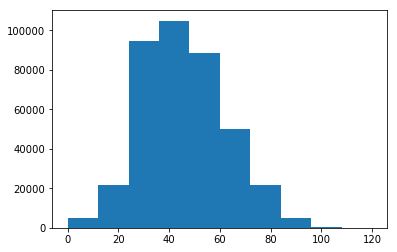

In [18]:
plt.hist(age);

Even if we cannot be certain about this, since there is no information about this on the dataset, we can safely assume that values for age that are above 110 are probably typos or outliers. It might also be the way that it was inputed when the value of 'age' for that patient was missing: since there are no NaN values and yet, 97 98 and 99 which were used in the other columns to indicate missing values, clearly cannot be used in this one.
So we will remove the columns that have the age value>110.

In [19]:
df.drop(df.loc[df['AGE']>110].index, inplace=True)

In [20]:
df['AGE'].value_counts()

37     9019
45     8925
40     8909
30     8899
46     8891
       ... 
103       6
102       3
105       2
104       1
106       1
Name: AGE, Length: 107, dtype: int64

Now that we have taken care of the outliers for this column in the Dataframe we can remove it to add it again once we finish the rest of the data processing.

In [21]:
df.drop('AGE', axis=1, inplace=True)

In [22]:
for i in df.columns:
    df[i]=df[i].replace([97,98,99], np.NaN)

In [23]:
df.isna().sum()

SEX                    0
PATIENT_TYPE           0
PNEUMONIA              4
PREGNANT          210870
DIABETES            1440
COPD                1313
ASTHMA              1309
INMSUPR             1449
HIPERTENSION        1388
OTHER_DISEASE       2136
CARDIOVASCULAR      1391
OBESITY             1353
RENAL_CHRONIC       1350
TOBACCO             1433
dtype: int64

As we saw before most missing values are in the column "PREGNANT".
<br>We want to replace them but not just with the mode, but keeping the same percentage of values from the original data.
<br>We will look at how the percentage is distributed, filtering out for now the null values.

In [24]:
preg=pd.DataFrame()
preg=df['PREGNANT']
preg.drop(preg.loc[preg>3].index, inplace=True)

In [25]:
preg.value_counts(normalize=True)

2.0    0.984793
1.0    0.015207
Name: PREGNANT, dtype: float64

This tells us the true percentage of people pregnant and not pregnant. We will use these as the percentages for filling the NaN values.

In [26]:
df['PREGNANT'].fillna(np.random.choice([1, 2], 
                                    p=[0.02,0.98]), inplace=True)

In [27]:
df['PREGNANT'].value_counts()

2.0    389222
1.0      2754
Name: PREGNANT, dtype: int64

In [28]:
df.isna().sum()

SEX                  0
PATIENT_TYPE         0
PNEUMONIA            4
PREGNANT             0
DIABETES          1440
COPD              1313
ASTHMA            1309
INMSUPR           1449
HIPERTENSION      1388
OTHER_DISEASE     2136
CARDIOVASCULAR    1391
OBESITY           1353
RENAL_CHRONIC     1350
TOBACCO           1433
dtype: int64

Now we can reinsert the column 'AGE' and drop all the missing values.

In [29]:
df=pd.concat([df, age], axis=1)

In [30]:
df.dropna(inplace=True)

In [31]:
df.isna().sum()

SEX               0
PATIENT_TYPE      0
PNEUMONIA         0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
AGE               0
dtype: int64

In [32]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,65
2,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
4,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,68
5,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,40
6,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,77
1047934,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
1047935,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,70
1047936,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,32


Now to follow the usual convention of one hot encoding I want to change the values 2, which means no, into 0.
<br>This is true for all the columns except our target, 'PATIENT_TYPE' where 1 means they returned home and 2 means they were hospitalized. I will do this separately, and then assign the column to y.
For X I will do the necessary changes to df and then concat with 'AGE' that I dropped before.
<br>For sex it is going to be 1 for female and 0 for male.

In [33]:
df['PATIENT_TYPE']=df['PATIENT_TYPE'].replace(1, 0)
df['PATIENT_TYPE']=df['PATIENT_TYPE'].replace(2, 1)

In [34]:
y=df['PATIENT_TYPE']
y.value_counts(normalize=True)

0.0    0.717728
1.0    0.282272
Name: PATIENT_TYPE, dtype: float64

In [35]:
#I have to redifine age again because the old onw has some null values that I dropped.
age=df['AGE']

In [36]:
df.drop(['AGE', 'PATIENT_TYPE'], axis=1, inplace=True)

In [37]:
df=df.replace(2, 0)

In [38]:
df

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1047934,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1047936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df=pd.concat([df,age,y], axis=1)

To leave df as the dataframe with all the info (including patient_type), since we will need it later for graphs.

Now selecting our X.

In [40]:
X=df.drop(['PATIENT_TYPE'], axis=1)

In [41]:
X

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77
1047934,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1047935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70
1047936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


In [142]:
y

0          0.0
2          1.0
4          0.0
5          1.0
6          0.0
          ... 
1047933    1.0
1047934    0.0
1047935    0.0
1047936    0.0
1047937    0.0
Name: PATIENT_TYPE, Length: 388876, dtype: float64

At this point I took care of the missing values and I don't need to do one hot encoding.
<br>I have my X and y, I can divide in train and test and start trying some models.

### Splitting into train and test set

In [42]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

Scaling the data:

In [43]:
# Instantiate StandardScaler
scaler = MinMaxScaler()
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert into a DataFrame
X_train = pd.DataFrame(scaled_data_train, columns=X.columns)
X_train.head()

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.619048
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.638095
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.638095


### Preliminary model with Logistic Regression:

A simple model that we can use as a baseline is Logistic Regression.<br> I works similarly to Linear Regression but it can make predictions on categorical data, splitting continuous intervals into bins.

In [44]:
logreg = LogisticRegression(max_iter=500, random_state=19)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=500, random_state=19)

In [45]:
pred_train_log = logreg.predict(X_train)

We will take a chance here to define a few functions that will help us preview our results.

In [46]:
# defined so that I can use it for test or train
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [47]:
def plot_matrix(labels, preds, cmap=None):
    cm = confusion_matrix(labels, preds)
    # To Normalize
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="OrRd")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [149]:
def model_results(model):
    with plt.style.context('seaborn-talk'):
        
        print(f'\n{Fore.BLUE}TRAIN{Style.RESET_ALL}')
        y_preds_train=model.predict(X_train)
        print(classification_report(y_train, y_preds_train))
#       print_metrics(y_train, y_preds_train)
        yhat_tr = model.predict_proba(X_train)
        yhat_tr = yhat_tr[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, yhat_tr)
        roc_score_train = roc_auc_score(y_train, yhat_tr)
#        auc_train=auc(fpr, tpr)
        print("Accuracy Score Train: {}".format(accuracy_score(y_train, y_preds_train)))    
        print(f"Train Roc_Auc Score: {roc_score_train :.2%}")
#        print(f"Train AUC Score: {auc_train :.2%}")
        print(f'\n{Fore.GREEN}TEST{Style.RESET_ALL}')
        y_preds_test=model.predict(X_test)
#        print_metrics(y_test, y_preds_test)
        print(classification_report(y_test, y_preds_test))        
        yhat_ts = model.predict_proba(X_test)
        yhat_ts = yhat_ts[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat_ts)
        roc_score_test = roc_auc_score(y_test, yhat_ts)
        print("Accuracy Score Test: {}".format(accuracy_score(y_test, y_preds_test)))
        print(f"Test Roc_Auc Score: {roc_score_test :.2%}\n")
#        print(f"Test AUC Score: {auc_test :.2%}")
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
        plot_confusion_matrix(model,X_train,y_train,normalize='true',ax=ax1,cmap='Oranges')
        ax1.grid(False)
        ax1.set_title("Train Confusion Matrix")
        plot_confusion_matrix(model,X_test,y_test,normalize='true',ax=ax2,cmap='Oranges')
        ax2.grid(False)
        ax2.set_title("Test Confusion Matrix")
        plt.show()

In [200]:
def plot_roc(models):
    colors=['blue', 'green', 'red', 'purple','orange', 'm', 'c', 'cyan', 'lime' ]
    lines=['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']
    plt.figure(figsize=(10,8))
    for i, j, k in zip(models, lines, colors):
        yhat = i.predict_proba(X_test)
        yhat = yhat[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        plt.plot(fpr, tpr, label=i, alpha=0.6, linestyle=j, color=k, linewidth=1.5)
    plt.plot([0, 1], [0, 1], color='pink', label='No Skill', linewidth=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Test') 
    plt.legend(loc='lower right', fontsize=12)
    plt.show()


In [201]:
def compare_roc(model):
    plt.figure(figsize=(10,8))
    yhat_train = model.predict_proba(X_train)
    yhat_train = yhat_train[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, yhat_train)
    plt.plot(fpr, tpr, label='train', alpha=0.6, color='green', linewidth=2)
    yhat_test = model.predict_proba(X_test)
    yhat_test = yhat_test[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
    plt.plot(fpr, tpr, label='test', alpha=0.6, linestyle='--', color='r', linewidth=2)
    yhat_log = logreg.predict_proba(X_test)
    yhat_log = yhat_log[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat_log)
    plt.plot(fpr, tpr, label='LogisticRegression', alpha=0.6,linestyle='dotted', color='b', linewidth=2)
    plt.plot([0, 1], [0, 1], color='pink', linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right', fontsize=12)
    plt.show()

### Metrics:
The model that we are trying to build is a classification model, meaning for each entry (patient) we are trying to determine to which **class** they belong.
<br>This classification problem is binary because in our target we have two classes, which represent whether the patient was sent home (0) or hospitalized (1).
<br>If we identify the result correctly, we will have a **True Positive** if we predicted that the patient was hospitalized, and they did, or a **True Negative** if we predict that the patient was not going to be hospitalized, and they didn't.
<br>If we predict that a patient is going to be hospitalized, and they are not that is a **False Positive** and if we predict that they won't be hospitalized, and instead they are, that is a **False Negative**.
<br> Given all these, we have a few different functions that underline certain aspects of the results of our model.
<br> Precision indicated
<br> Recall indicates
<br> Accuracy describes
<br> The F1 score is used 

**Results of Logistic Regression:**

In [51]:
print_metrics(y_train, pred_train_log)

Precision Score: 0.8450481660436989
Recall Score: 0.6759686907482133
Accuracy Score: 0.8736255258745719
F1 Score: 0.7511108109933149


**Confusion Matrix**:



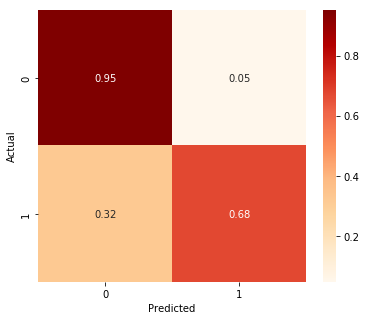

In [52]:
plot_matrix(y_train, pred_train_log)

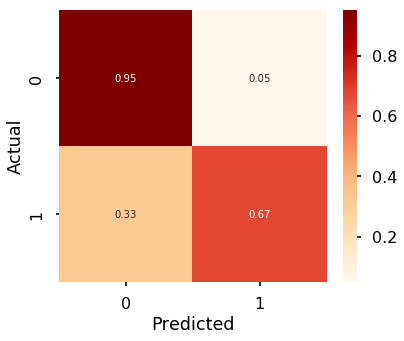

In [188]:
pred_test_log=logreg.predict(X_test)
plot_matrix(y_test, pred_test_log)

**ROC Curve:**
Explain blah blah blah ROC curve

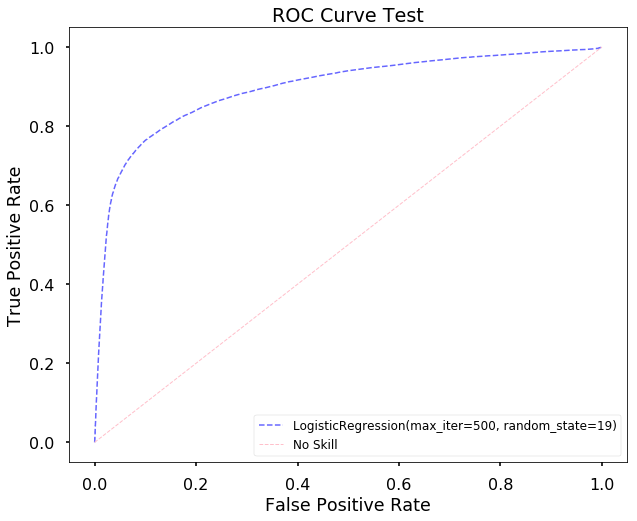

In [202]:
plot_roc([logreg])

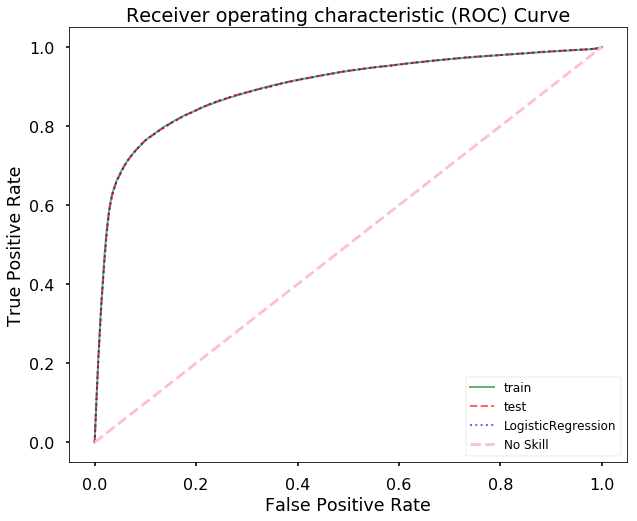

In [203]:
compare_roc(logreg)

### Decision tree
The Logistic Regression Model will be kept as our baseline model.
<br>We will try next with a Decision Tree, and see if it performs better.

In [57]:
#Create the tree
DT1 = DecisionTreeClassifier(criterion='entropy', random_state=19)

In [58]:
# fit the tree
DT1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=19)

Results for the Decision Tree Model

TRAIN
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    209381
         1.0       0.87      0.70      0.78     82276

    accuracy                           0.89    291657
   macro avg       0.88      0.83      0.85    291657
weighted avg       0.89      0.89      0.88    291657

Accuracy Score Train: 0.8865653833098468
Train Roc_Auc Score: 91.65%

TEST
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     69726
         1.0       0.83      0.67      0.74     27493

    accuracy                           0.87     97219
   macro avg       0.86      0.81      0.83     97219
weighted avg       0.87      0.87      0.86     97219

Accuracy Score Test: 0.868410495890721
Test Roc_Auc Score: 87.24%



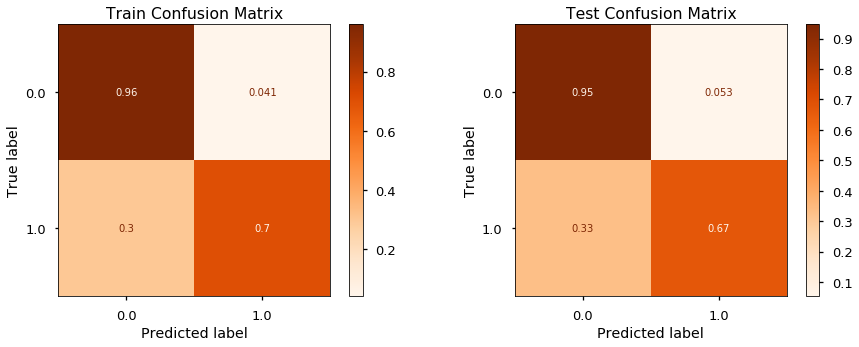

In [150]:
# Evaluate the tree
preds_train_DT1 = DT1.predict(X_train)
print(f'{Fore.RED}Results for the Decision Tree Model')
model_results(DT1)

We can see that the tree is overfitting blah blah blah

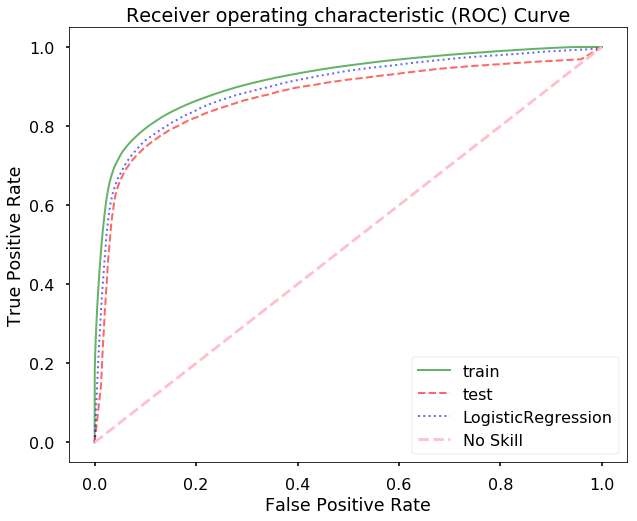

In [196]:
compare_roc(DT1)

In [197]:
#plot_roc([logreg,DT1])

Another possibility that we have with decision trees is that we can extract their feature importance.

In [62]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(5,5))
    #not sure why when I add np.sort in front of model feature it changes
    plt.barh(range(n_features), (model.feature_importances_), align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

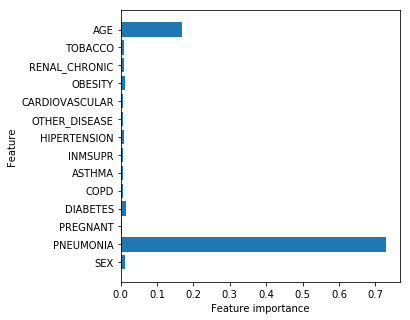

In [63]:
plot_feature_importances(DT1)

In [64]:
#resu_DT1=save_metrics(DT1, y_train, preds_train_DT1)

In [65]:
#resu_DT1

A few more information that we can retrieve about our tree:

In [66]:
print(f'Decision Tree has {DT1.tree_.node_count} nodes with a maximum depth of {DT1.tree_.max_depth}.')
print(f'Model Accuracy for train data: {DT1.score(X_train, y_train)}')

Decision Tree has 22413 nodes with a maximum depth of 31.
Model Accuracy for train data: 0.8865653833098468


### Class Imbalance
<br> One thing we have not considered yet is the fact that the classes of our target (patients sent home vs. patients hospitalized) are not balanced. They are not present equally in our dataset but around 70% of the patients were sent home and only 30% were hospitalized, as we saw from the split of the data for that column.
<br> This means that a very basic model that simply predicts all the patients to be sent home would have a 70% accuracy, that's the baseline.
<br> We have a way to counteract this problem by balancing the classes with a decision tree, by specifying `class_weight='balanced'`.

In [67]:
DT_bal = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=19)

In [68]:
DT_bal.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=19)

In [69]:
preds_train_DTbal = DT_bal.predict(X_train)

Results for the Decision Tree Model considering class imbalance

TRAIN
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91    209381
         1.0       0.76      0.79      0.78     82276

    accuracy                           0.87    291657
   macro avg       0.84      0.85      0.84    291657
weighted avg       0.87      0.87      0.87    291657

Accuracy Score Train: 0.8701591252738662
Train Roc_Auc Score: 91.65%

TEST
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     69726
         1.0       0.73      0.76      0.74     27493

    accuracy                           0.85     97219
   macro avg       0.82      0.82      0.82     97219
weighted avg       0.85      0.85      0.85     97219

Accuracy Score Test: 0.8525493987800739
Test Roc_Auc Score: 87.26%



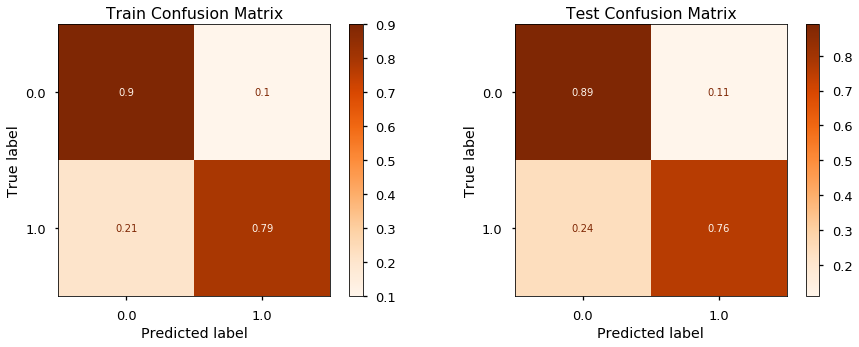

In [151]:
# Evaluate the tree
print(f'{Fore.RED}Results for the Decision Tree Model considering class imbalance')
model_results(DT_bal)

Still overfitting, better recall, lower accuracy but better Roc_Auc

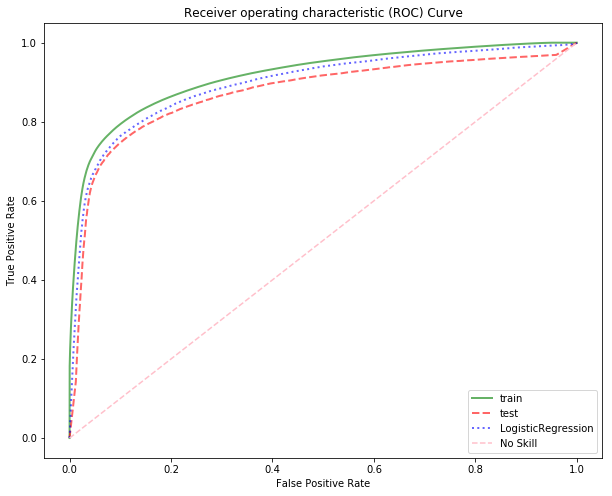

In [71]:
compare_roc(DT_bal)

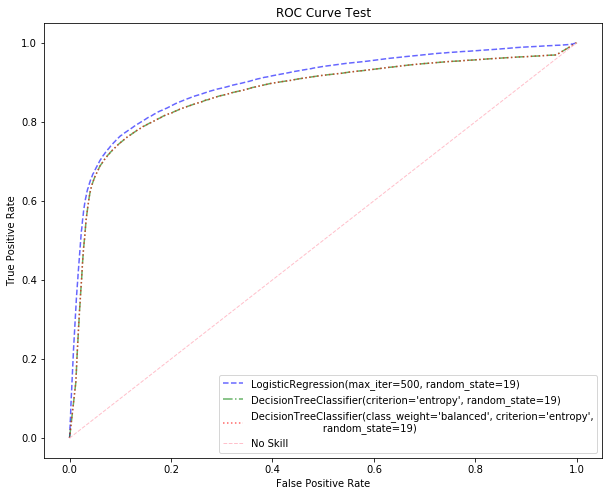

In [72]:
plot_roc([logreg, DT1, DT_bal])

As we can see from the confusion matrix we started to have more False Positives and the predictions of the majority class (0, people returned home) has decreased. This reflects also in the accuracy score and F1 score.
<br> But on the bright side the predictions for the minority class (1, hospitalized) have improved, with less false negatives and a recall that went from 0.63 to 0.77.
<br> This is a matter of choice for the stakeholder, which model to use. The Decision tree without class imbalance leads to an overall more precise model: less falses overall, negative and positive, more patients categorized correctly.
<br> On the other hand the model that accounts for class imbalance makes more mistakes, has lower accurcay precision and F1 score, but it has overall less false negatives.
<br>Given the specific problem we would recommend staying on the safer side, trying to minimize the false negatives then the false positives, because it would be less of a loss to be prepared for one extra patient that doesn't ultimately need to be hospitalized, rather then not being ready with the equippment for one that actually needs to be.

### Random Forest

Explain a bit anout Random Forest Classifier.

In [73]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(random_state=19)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=19)

Results for the Random Forest Model

TRAIN
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    209381
         1.0       0.86      0.71      0.78     82276

    accuracy                           0.89    291657
   macro avg       0.88      0.83      0.85    291657
weighted avg       0.89      0.89      0.88    291657

Accuracy Score Train: 0.8865550972546519
Train Roc_Auc Score: 91.42%

TEST
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     69726
         1.0       0.83      0.68      0.75     27493

    accuracy                           0.87     97219
   macro avg       0.86      0.81      0.83     97219
weighted avg       0.87      0.87      0.87     97219

Accuracy Score Test: 0.8699842623355517
Test Roc_Auc Score: 89.04%



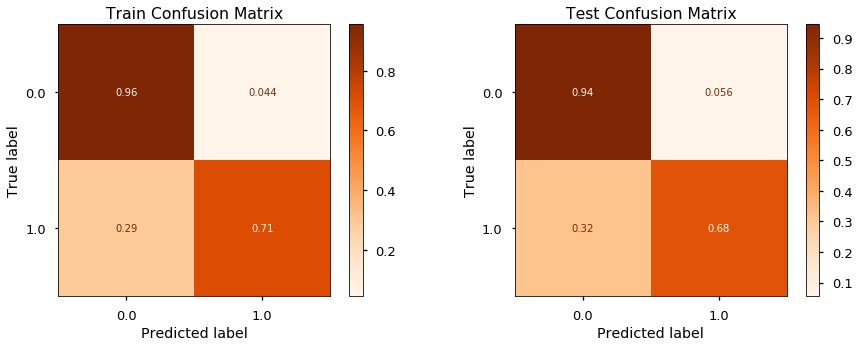

In [152]:
print(f'{Fore.RED}Results for the Random Forest Model')
model_results(forest)

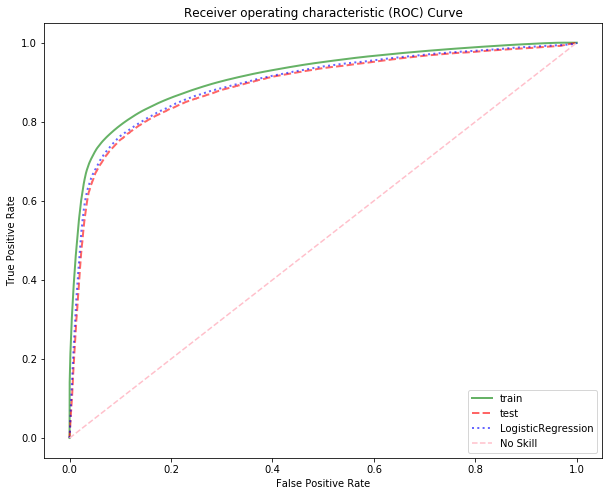

In [79]:
compare_roc(forest)

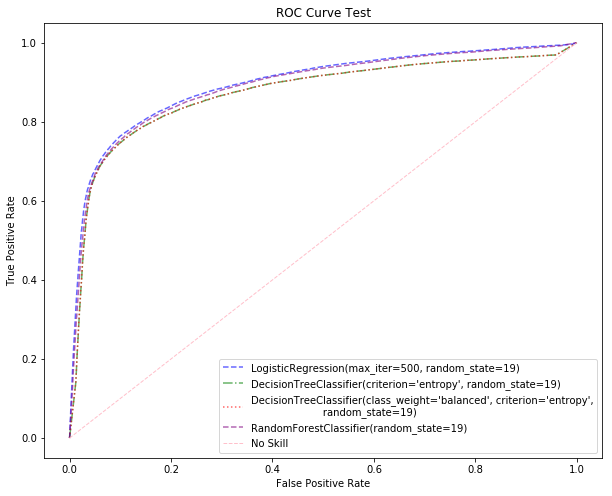

In [80]:
plot_roc([logreg, DT1, DT_bal, forest])

In [81]:
#resu_forest=save_metrics(forest, y_train, preds_for)

### Random Forest class imbalance:
Now accounting for the class imbalance in Random Forest.

In [82]:
forest_bal = RandomForestClassifier(random_state=19, class_weight='balanced')
forest_bal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=19)

Results for the Random Forest Model considering class imbalance

TRAIN
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91    209381
         1.0       0.77      0.79      0.78     82276

    accuracy                           0.87    291657
   macro avg       0.84      0.85      0.84    291657
weighted avg       0.87      0.87      0.87    291657

Accuracy Score Train: 0.8721203331310409
Train Roc_Auc Score: 91.45%

TEST
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     69726
         1.0       0.74      0.75      0.75     27493

    accuracy                           0.86     97219
   macro avg       0.82      0.82      0.82     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8555529268970057
Test Roc_Auc Score: 88.74%



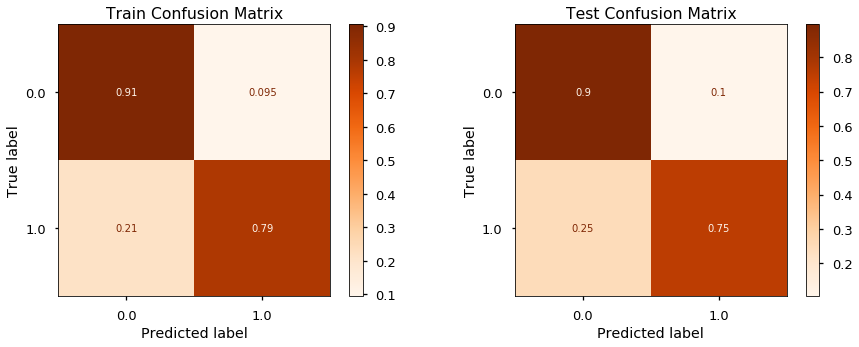

In [153]:
print(f'{Fore.RED}Results for the Random Forest Model considering class imbalance')
model_results(forest_bal)

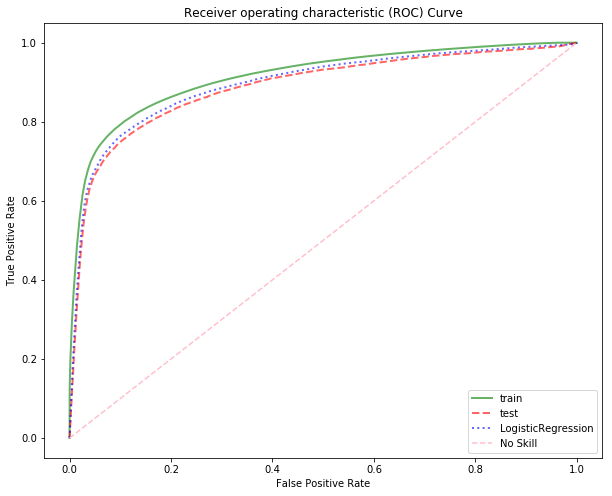

In [86]:
compare_roc(forest_bal)

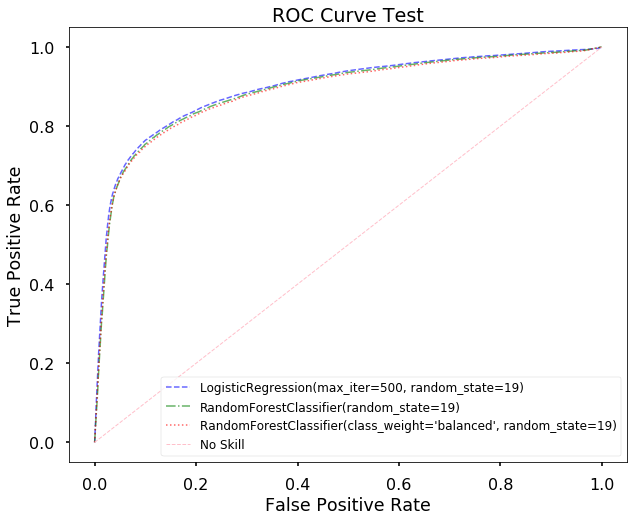

In [204]:
plot_roc([logreg, forest, forest_bal])

### GridSearchCV for Random Forest:

Explain what is GridSearch

In [88]:
# create the grid with parameters:

rf_param_grid = { 'n_estimators':[10,30,100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 6, 10, 30],
                 'min_samples_split':[5, 10],
                 'min_samples_leaf':[3, 6]
    
}

In [89]:
""" code with which we ran the GridSearchCV
rf_grid_search = GridSearchCV(forest_bal, rf_param_grid,cv=3)
rf_grid_search.fit(X_train, y_train)"""

' code with which we ran the GridSearchCV\nrf_grid_search = GridSearchCV(forest_bal, rf_param_grid,cv=3)\nrf_grid_search.fit(X_train, y_train)'

Since the model took a very long time to fit I am going to pickle it, to save it for a later rerun without it having to fit again.

In [90]:
filename = 'CVforest.pkl'

In [91]:
""" code with which we saved the model
# save the model to disk

joblib.dump(rf_grid_search, filename)
"""

' code with which we saved the model\n# save the model to disk\n\njoblib.dump(rf_grid_search, filename)\n'

In [92]:
# some time later...

# load the model from disk
loaded_model = joblib.load(filename)

In [93]:
forest_accuracy=loaded_model.best_score_ 
best_params=loaded_model.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 86.63%

Best Parameters:{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}


In [94]:
for_CV1 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='entropy',
                                 max_depth= 6, min_samples_leaf= 6, min_samples_split= 5,n_estimators=10)

In [95]:
for_CV1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=10, random_state=19)

In [96]:
preds_forCV1=for_CV1.predict(X_train)

Results for the Random Forest model with best parameters after First GridSeachCV

TRAIN
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91    209381
         1.0       0.77      0.74      0.75     82276

    accuracy                           0.86    291657
   macro avg       0.84      0.83      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8645223670270215
Train Roc_Auc Score: 89.50%

TEST
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     69726
         1.0       0.77      0.74      0.75     27493

    accuracy                           0.86     97219
   macro avg       0.83      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8636274802250589
Test Roc_Auc Score: 89.44%



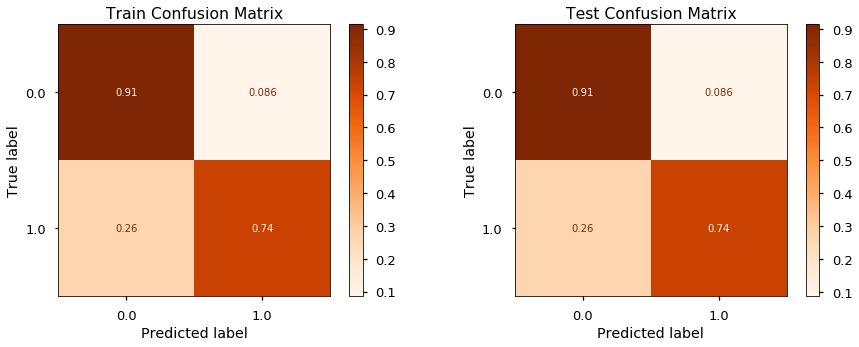

In [154]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after First GridSeachCV')
model_results(for_CV1)

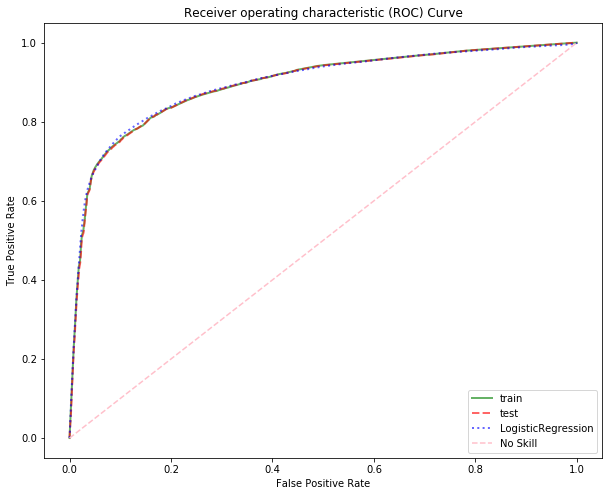

In [98]:
compare_roc(for_CV1)

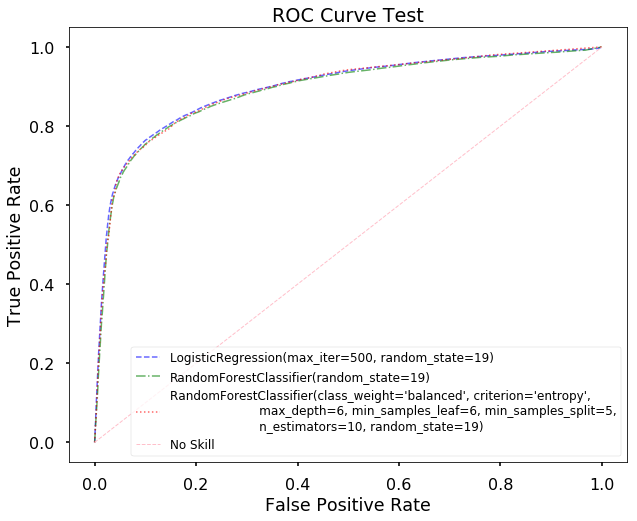

In [205]:
plot_roc([logreg, forest,  for_CV1])

Now we are going to try a second Gridsearch blah blah.

In [215]:
rf_param_grid2 = { 'n_estimators':[10, 15],
                 'criterion': ['entropy'],
                 'max_depth': [None,3,6],
                 'min_samples_split':[1,3,5],
                 'min_samples_leaf':[6, 10, 20]
    
}

In [216]:
"""Code with which we ran the second gridsearch
rf_grid_search2 = GridSearchCV(forest_bal, rf_param_grid,cv=3)
rf_grid_search2.fit(X_train, y_train)"""

'Code with which we ran the second gridsearch\nrf_grid_search2 = GridSearchCV(forest_bal, rf_param_grid,cv=3)\nrf_grid_search2.fit(X_train, y_train)'

In [217]:
filename2 = 'CVforest3.pkl'

In [218]:
"""Code with which we saved the third gridserch
joblib.dump(rf_grid_search2, filename2)
"""

'Code with which we saved the third gridserch\njoblib.dump(rf_grid_search2, filename2)\n'

In [219]:
# some time later...

# load the model from disk
loaded_model2 = joblib.load(filename2)

In [220]:
forest_accuracy=loaded_model2.best_score_ 
best_params=loaded_model2.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 86.63%

Best Parameters:{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}


In [223]:
for_CV2 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='entropy', max_depth= 6,
                                 min_samples_leaf= 6, min_samples_split=5, n_estimators= 10)
for_CV2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=10, random_state=19)

Results for the Random Forest model with best parameters after the second GridSeachCV

TRAIN
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91    209381
         1.0       0.77      0.74      0.75     82276

    accuracy                           0.86    291657
   macro avg       0.84      0.83      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8645223670270215
Train Roc_Auc Score: 89.50%

TEST
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     69726
         1.0       0.77      0.74      0.75     27493

    accuracy                           0.86     97219
   macro avg       0.83      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8636274802250589
Test Roc_Auc Score: 89.44%



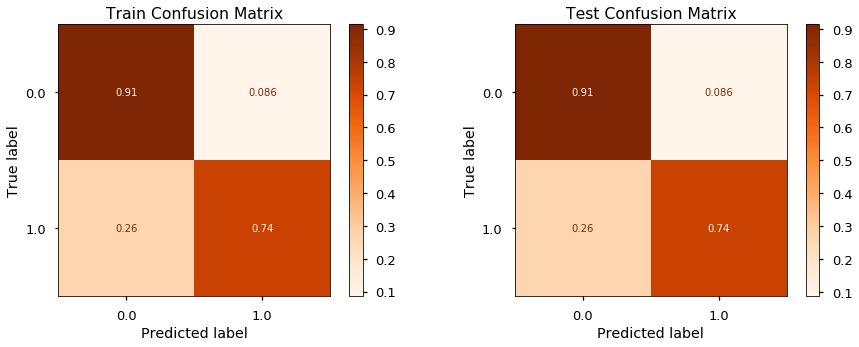

In [224]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after the second GridSeachCV')
model_results(for_CV2)

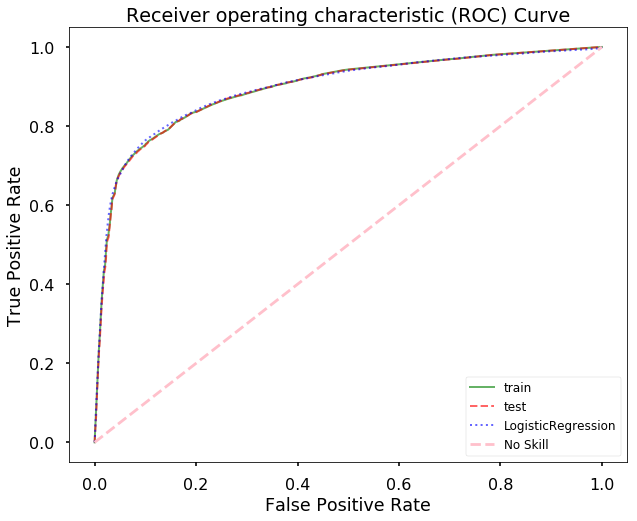

In [225]:
compare_roc(for_CV2)

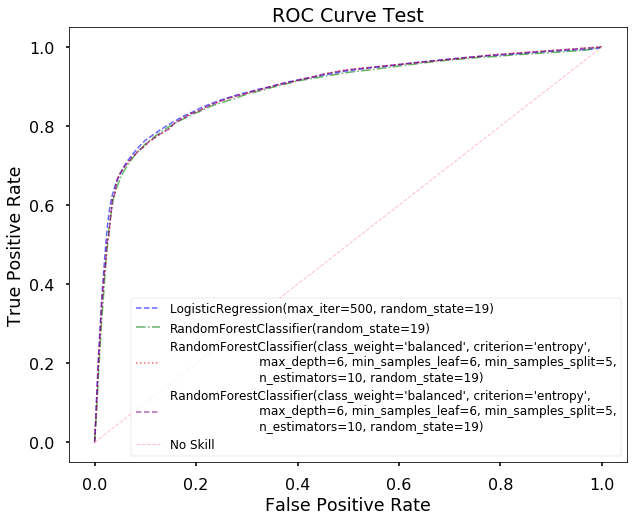

In [226]:
plot_roc([logreg,forest, for_CV1, for_CV2])

Now running the third GridSearch CV:

In [206]:
rf_param_grid3 = { 'n_estimators':[20,30,40],
                 'criterion': ['gini'],
                 'max_depth':[None],
                 'min_samples_split':[3,5],
                 'min_samples_leaf':[5, 10, 20]
    
}

In [207]:
"""Code with which we ran the third grid search
rf_grid_search3 = GridSearchCV(forest_bal, rf_param_grid3,cv=3)
rf_grid_search3.fit(X_train, y_train)"""

'Code with which we ran the second grid search\nrf_grid_search3 = GridSearchCV(forest_bal, rf_param_grid3,cv=3)\nrf_grid_search3.fit(X_train, y_train)'

In [208]:
filename3 = 'forGrid2.pkl'

In [209]:
""" code with which we saved the model
# save the model to disk

joblib.dump(rf_grid_search3, filename3)
"""

' code with which we saved the model\n# save the model to disk\n\njoblib.dump(rf_grid_search3, filename3)\n'

In [210]:
# some time later...

# load the model from disk
loaded_model3 = joblib.load(filename3)

In [270]:
loaded_model3.score(X_test)

ValueError: Expected array-like (array or non-string sequence), got None

In [211]:
forest_accuracy=loaded_model3.best_score_ 
best_params=loaded_model3.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 85.66%

Best Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 30}


In [212]:
for_CV3 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='gini', max_depth= None, 
                                 min_samples_leaf= 5, min_samples_split= 3, n_estimators=30)

In [213]:
for_CV3.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=3, n_estimators=30, random_state=19)

Results for the Random Forest model with best parameters after Third GridSeachCV

TRAIN
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90    209381
         1.0       0.74      0.78      0.76     82276

    accuracy                           0.86    291657
   macro avg       0.83      0.84      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8622422914588026
Train Roc_Auc Score: 90.67%

TEST
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     69726
         1.0       0.74      0.77      0.76     27493

    accuracy                           0.86     97219
   macro avg       0.82      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8585564550139376
Test Roc_Auc Score: 89.87%



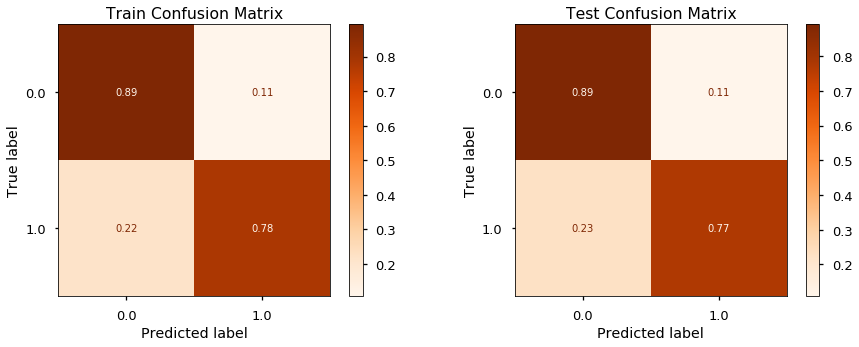

In [214]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after Third GridSeachCV')
model_results(for_CV3)

Results for the Random Forest model with best parameters after Second GridSeachCV

TRAIN
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90    209381
         1.0       0.74      0.78      0.76     82276

    accuracy                           0.86    291657
   macro avg       0.83      0.84      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8622422914588026
Train Roc_Auc Score: 90.67%

TEST
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     69726
         1.0       0.74      0.77      0.76     27493

    accuracy                           0.86     97219
   macro avg       0.82      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8585564550139376
Test Roc_Auc Score: 89.87%



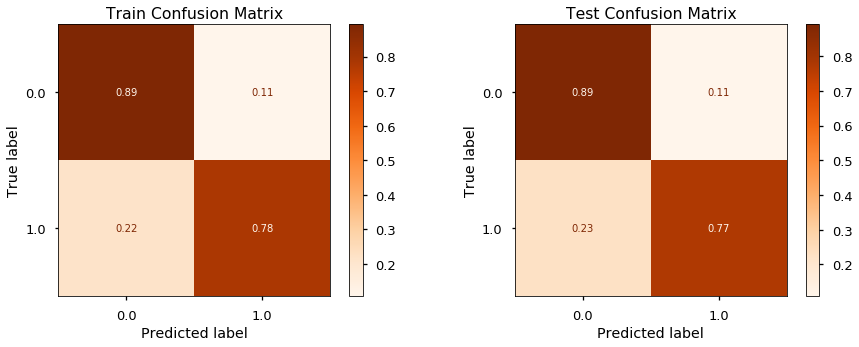

In [155]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after Second GridSeachCV')
model_results(for_CV3)

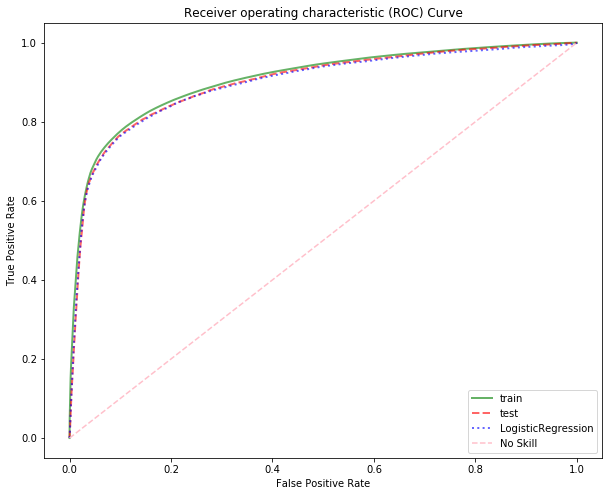

In [111]:
compare_roc(for_CV3)

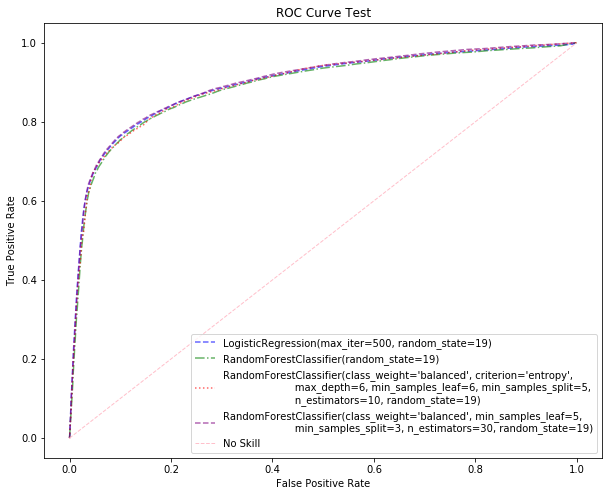

In [112]:
plot_roc([logreg, forest, for_CV1, for_CV2, for_CV3])

In [271]:
rf_param_grid4 = { 'n_estimators':[30],
                 'criterion': ['gini'],
                 'max_depth':[None],
                 'min_samples_split':[2,3],
                 'min_samples_leaf':[2,3,5]
    
}

In [272]:
rf_grid_search4 = GridSearchCV(forest_bal, rf_param_grid4,cv=3)
rf_grid_search4.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=19),
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3], 'n_estimators': [30]})

In [273]:
filename4 = 'forGrid4.pkl'

In [274]:
#save the model to disk

joblib.dump(rf_grid_search4, filename4)


['forGrid4.pkl']

In [275]:
# some time later...

# load the model from disk
loaded_model4 = joblib.load(filename4)

In [276]:
forest_accuracy=loaded_model4.best_score_ 
best_params=loaded_model4.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 85.66%

Best Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 30}


In [277]:
for_CV4 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='gini', max_depth= None, 
                                 min_samples_leaf= 5, min_samples_split= 2, n_estimators=30)

In [278]:
for_CV4.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=30, random_state=19)

Results for the Random Forest model with best parameters after Fourth GridSeachCV

TRAIN
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90    209381
         1.0       0.74      0.78      0.76     82276

    accuracy                           0.86    291657
   macro avg       0.83      0.84      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8622422914588026
Train Roc_Auc Score: 90.67%

TEST
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     69726
         1.0       0.74      0.77      0.76     27493

    accuracy                           0.86     97219
   macro avg       0.82      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8585564550139376
Test Roc_Auc Score: 89.87%



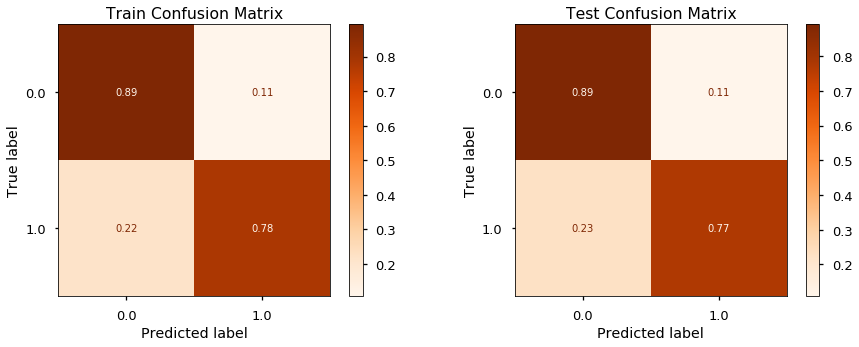

In [279]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after Fourth GridSeachCV')
model_results(for_CV4)

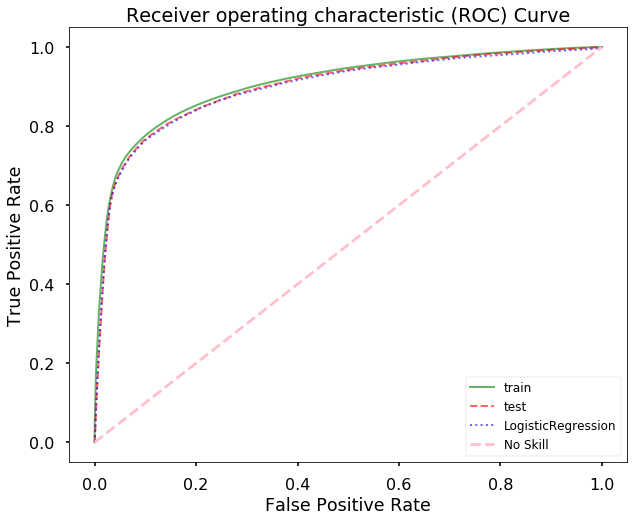

In [280]:
compare_roc(for_CV4)

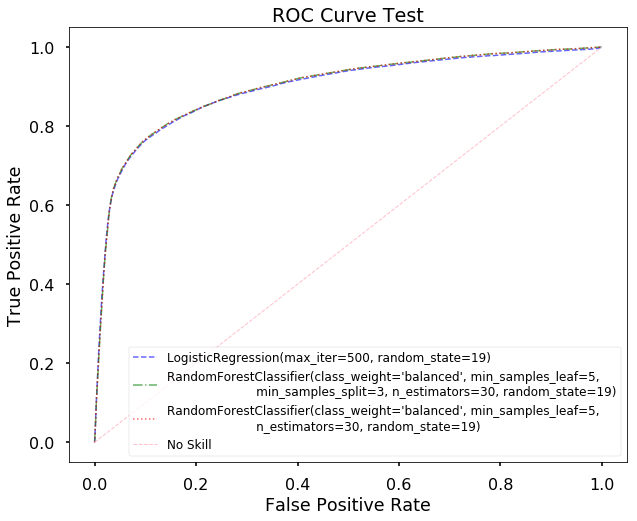

In [281]:
plot_roc([logreg, for_CV3, for_CV4])

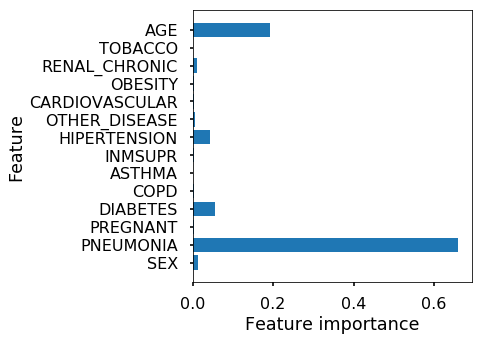

In [301]:
plot_feature_importances(for_CV3)

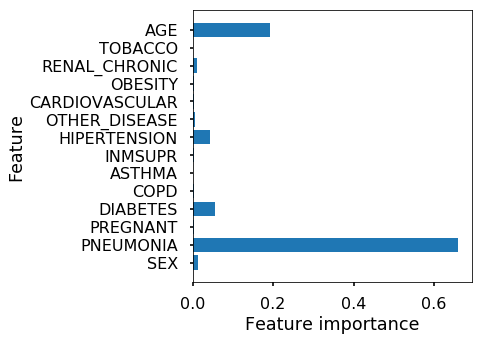

In [302]:
plot_feature_importances(for_CV4)

### Gradient Boosting

Explain what is Gradient Boosting:

In [126]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [127]:
gbc.score(X_test, y_test)

0.8747878501116036

In [128]:
recall_score(y_test, gbc.predict(X_test))

0.6797730331357072

Results for the Gradient Boost model

TRAIN
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92    209381
         1.0       0.85      0.68      0.76     82276

    accuracy                           0.88    291657
   macro avg       0.87      0.82      0.84    291657
weighted avg       0.87      0.88      0.87    291657

Accuracy Score Train: 0.8758438851116208
Train Roc_Auc Score: 90.11%

TEST
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     69726
         1.0       0.85      0.68      0.75     27493

    accuracy                           0.87     97219
   macro avg       0.87      0.82      0.84     97219
weighted avg       0.87      0.87      0.87     97219

Accuracy Score Test: 0.8747878501116036
Test Roc_Auc Score: 90.03%



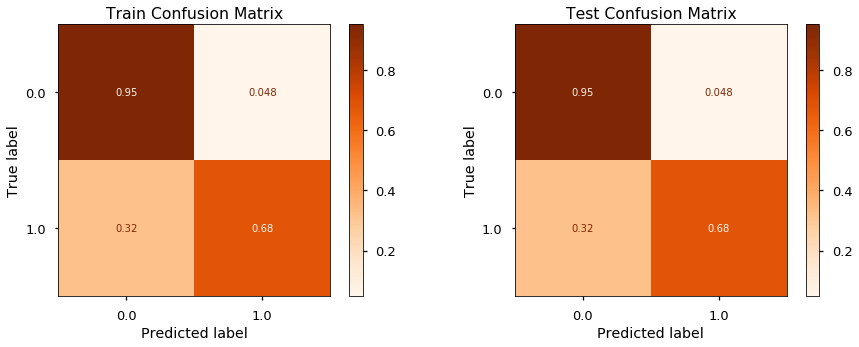

In [157]:
print(f'{Fore.RED}Results for the Gradient Boost model')
model_results(gbc)

In [134]:
#cross_val_score(gbc, X_train, y_train, cv=5)

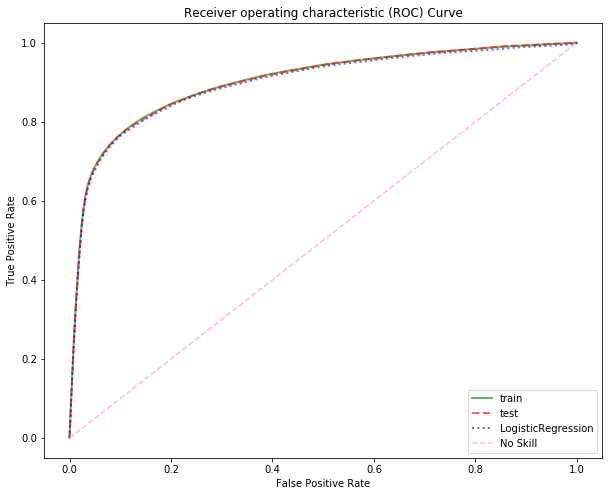

In [135]:
compare_roc(gbc)

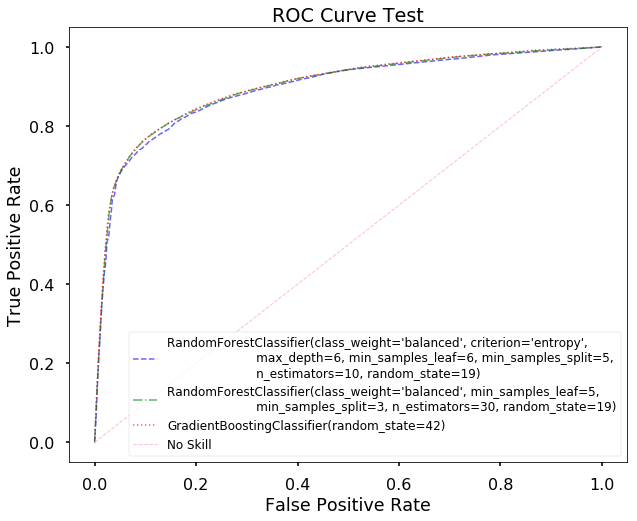

In [252]:
plot_roc([for_CV1,for_CV3, gbc])

# To draw some conclusions:
Now in order to draw some conclusions let us look at the results of the different models together and we will plot the ROC curve for all the different models we saw.
<br>Once we can identify the best model we can see what the most important features were for that model.

In [286]:
models=[for_CV3, for_CV4, gbc]

In [287]:
recalls=[]
F1s=[]
roc_aucs=[]
for i in (models):
    preds=i.predict(X_test)
    recalls.append(recall_score(y_test, preds))
    F1s.append(f1_score(y_test, preds))
    yhat_ts = i.predict_proba(X_test)
    yhat_ts = yhat_ts[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat_ts)
    roc_score_test = roc_auc_score(y_test, yhat_ts)
    roc_aucs.append(roc_score_test)

In [288]:
results=pd.DataFrame([])
results['model']=['for_CV3','for_CV4', 'gbc']
results['recall']=recalls
results['F1']=F1s
results['AUC']=roc_aucs
results

,model,recall,F1,AUC
0,for_CV3,0.774779,0.755985,0.898740
1,for_CV4,0.774779,0.755985,0.898740
2,gbc,0.679773,0.754334,0.900313


 Model  RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=3, n_estimators=30, random_state=19)


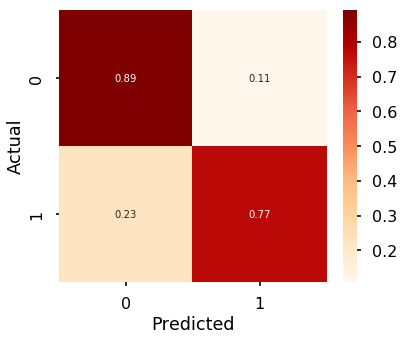

 Model  RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=30, random_state=19)


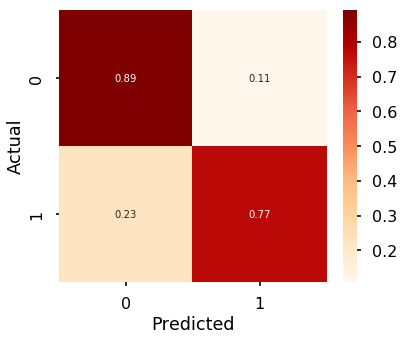

 Model  GradientBoostingClassifier(random_state=42)


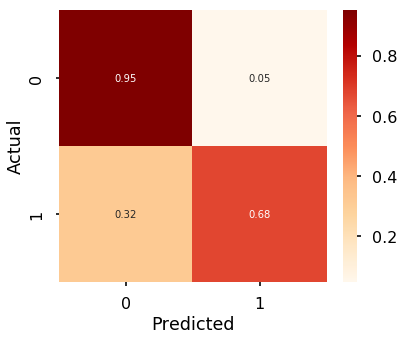

In [289]:
### Here I would compare just the 2/3 best confusion matrices
for i in (models):
    preds=i.predict(X_test)
    print(f"{Fore.BLUE} Model {Style.RESET_ALL}", i)
    plot_matrix(y_test,preds)

In [290]:
##Here if I want I could create a df with all the feature importances. But maybe not necessary.
# Feature Importance
feat=[]
imp=[]
mod=[]
for i in models:
    feature_used = df.columns
    for fi, feature in zip(i.feature_importances_, feature_used):
        imp.append(fi)
        feat.append(feature)

In [316]:
feat_imp=pd.DataFrame([])
feat_imp['model']=mod
feat_imp['features']=feat
feat_imp['importance']=imp

feat_imp['model'][0:14]='Forest CV3'
feat_imp['model'][14:28]='Forest CV4'
feat_imp['model'][28:]='GBoost'
feat_imp

,model,features,importance
0,Forest CV3,SEX,0.013391
1,Forest CV3,PNEUMONIA,0.660409
2,Forest CV3,PREGNANT,0.002169
3,Forest CV3,DIABETES,0.055221
4,Forest CV3,COPD,0.004533
5,Forest CV3,ASTHMA,0.001035
6,Forest CV3,INMSUPR,0.003263
7,Forest CV3,HIPERTENSION,0.043754
8,Forest CV3,OTHER_DISEASE,0.005421
9,Forest CV3,CARDIOVASCULAR,0.002235


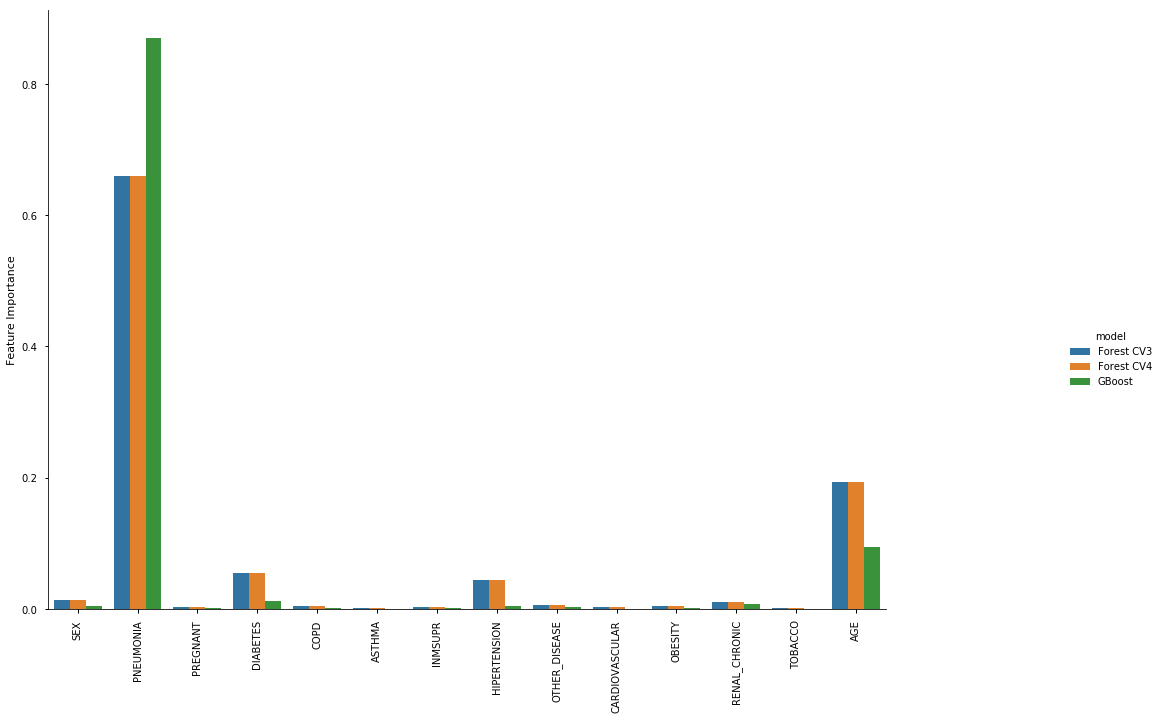

In [310]:
plt.style.use('seaborn-notebook')
#plt.figure(figsize=(30,15))
#features = sns.load_dataset("feat_imp")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=feat_imp, kind="bar",
    x="features", y="importance", hue="model", ci=None
#   ,aspect=10/8 , palette="dark", alpha=.6, height=6
)
g.set_axis_labels("", "Feature Importance")
g.fig.set_figwidth(18)
g.fig.set_figheight(10)
g.set_xticklabels(labels=feat, rotation=90);

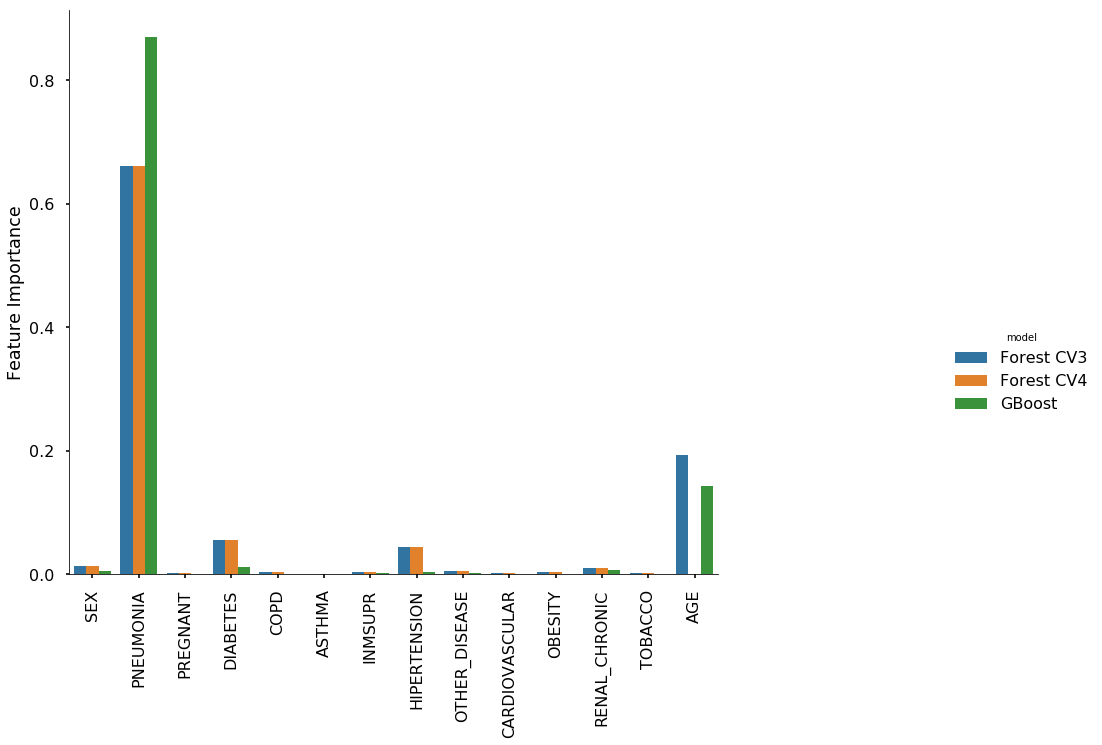

In [308]:
plt.style.use('seaborn-poster')
#plt.figure(figsize=(30,15))
#features = sns.load_dataset("feat_imp")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=feat_imp, kind="bar",
    x="features", y="importance", hue="model", ci=None
#   ,aspect=10/8 errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_axis_labels("", "Feature Importance")
g.fig.set_figwidth(18)
g.fig.set_figheight(10)
g.set_xticklabels(labels=feat, rotation=90);

In [311]:
feat_imp.groupby('features').sum()

,importance
features,
AGE,0.479717
ASTHMA,0.002321
CARDIOVASCULAR,0.004547
COPD,0.009790
DIABETES,0.122995
HIPERTENSION,0.092009
INMSUPR,0.008138
OBESITY,0.009576
OTHER_DISEASE,0.013457


In [313]:
models2=[DT_bal,forest_bal, for_CV2, for_CV4, gbc]

In [318]:
feat=[]
imp=[]
mod=[]
for i in models2:
    feature_used = df.columns
    for fi, feature in zip(i.feature_importances_, feature_used):
        imp.append(fi)
        feat.append(feature)

In [321]:
feat_imp=pd.DataFrame([])
feat_imp['model']=mod
feat_imp['features']=feat
feat_imp['importance']=imp

feat_imp['model'][0:14]='DT_bal'
feat_imp['model'][14:28]='Forest_bal'
feat_imp['model'][28: 42]='for_CV2'
feat_imp['model'][42: 56]='for_CV4'
feat_imp['model'][56:]='for_gbc'

feat_imp.head(70)

,model,features,importance
0,DT_bal,SEX,0.011196
1,DT_bal,PNEUMONIA,0.709233
2,DT_bal,PREGNANT,0.003692
3,DT_bal,DIABETES,0.020328
4,DT_bal,COPD,0.005014
...,...,...,...
65,for_gbc,CARDIOVASCULAR,0.000077
66,for_gbc,OBESITY,0.000798
67,for_gbc,RENAL_CHRONIC,0.006658
68,for_gbc,TOBACCO,0.000040


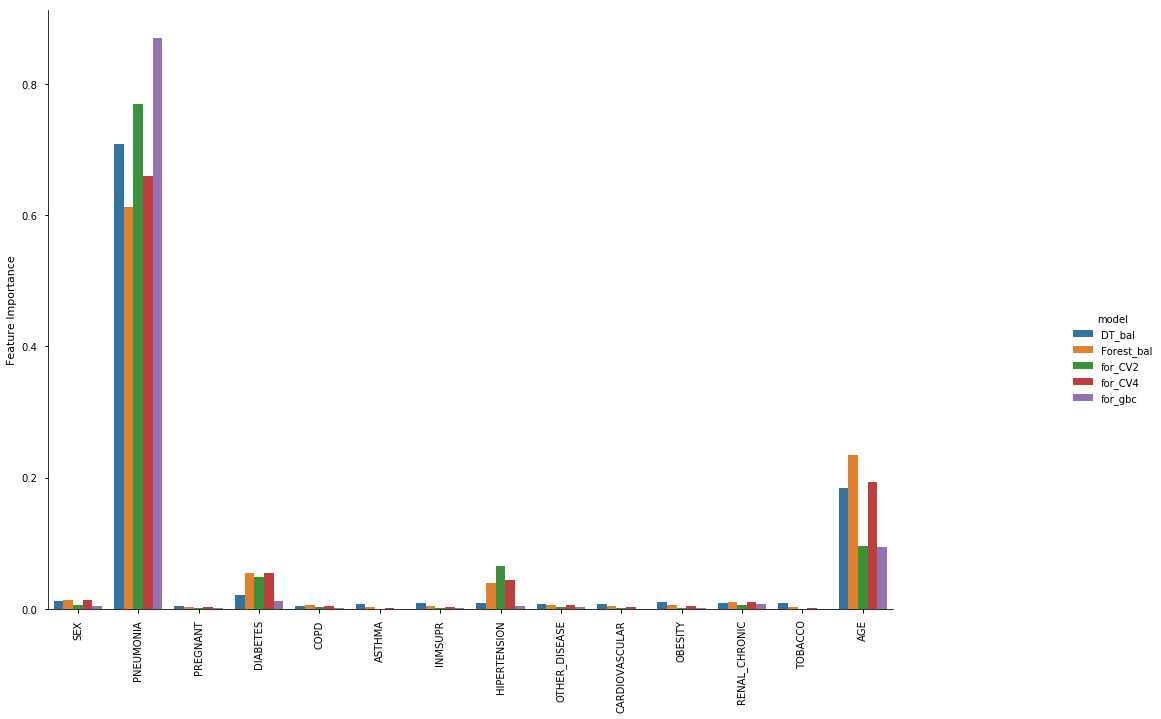

In [322]:
plt.style.use('seaborn-notebook')
#plt.figure(figsize=(30,15))
#features = sns.load_dataset("feat_imp")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=feat_imp, kind="bar",
    x="features", y="importance", hue="model", ci=None
#   ,aspect=10/8 , palette="dark", alpha=.6, height=6
)
g.set_axis_labels("", "Feature Importance")
g.fig.set_figwidth(18)
g.fig.set_figheight(10)
g.set_xticklabels(labels=feat, rotation=90);

In [323]:
feat_imp.groupby('features').sum()

,importance
features,
AGE,0.801525
ASTHMA,0.011104
CARDIOVASCULAR,0.013971
COPD,0.018145
DIABETES,0.189812
HIPERTENSION,0.161855
INMSUPR,0.019205
OBESITY,0.022668
OTHER_DISEASE,0.023919


From what we can observe the five most important features in our selection overall for the models are:
    Pneumonia, Age, Diabetes, Hypertension and Sex.
    Let us take a closer look at each one of these.

I should take the best model,
look at the list of Most Relevant Features,
and then study them.
For age, the only numeric one, I can divide it in bins and then plot for each bin the number of patients hospitalized.
To get a sense of what patients are more at risk.
For the other factors just say Drs can take care of those factors more, CDC could start campaigns and study more in depth people with those diseases.

### Pneumonia

In [166]:
df

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE,PATIENT_TYPE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77,1.0
1047934,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.0
1047935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70,0.0
1047936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,0.0


Let us study what was the distribution of patients with pneumonia.

Calculating the percentage of patients that had diabetes, whether they where hospitalized or not.

In [167]:
df.loc[df["PNEUMONIA"]==1]['PATIENT_TYPE'].value_counts(normalize=True)

1.0    0.856639
0.0    0.143361
Name: PATIENT_TYPE, dtype: float64

Calculating the percentage of patients that did not have diabetes, whether they where hospitalized or not.

In [168]:
df.loc[df["PNEUMONIA"]==0]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.877872
1.0    0.122128
Name: PATIENT_TYPE, dtype: float64

''

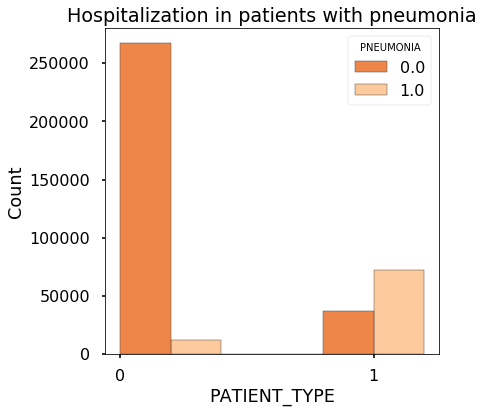

In [169]:
f, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df,
    x='PATIENT_TYPE', 
    hue="PNEUMONIA",
    palette='Oranges_r',
    edgecolor=".3",
    multiple="dodge",
    binwidth=0.4
)
ax.set_xticks([0,1])
ax.set_title('Hospitalization in patients with pneumonia')
;

### Age
good luck with that

''

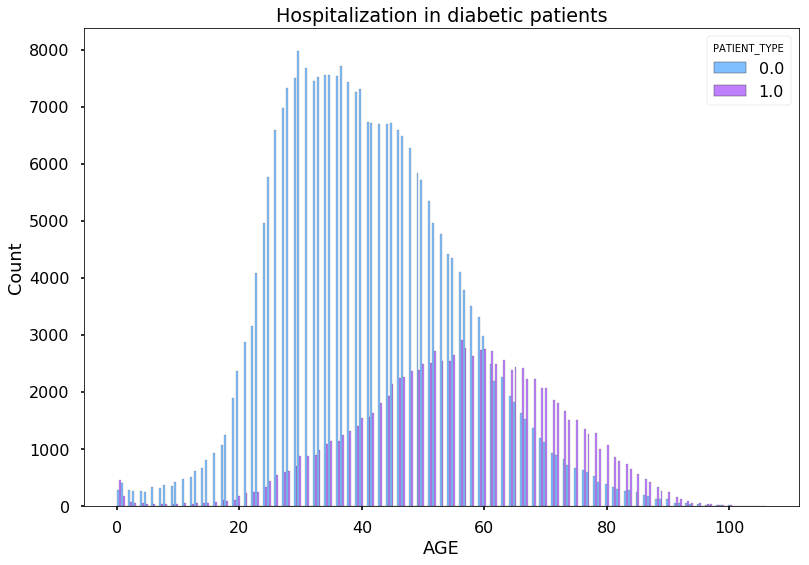

In [170]:
f, ax = plt.subplots()
sns.histplot(df,
    x='AGE', 
    hue="PATIENT_TYPE",
    palette='cool',
    edgecolor=".3",
    multiple="dodge",
)
ax.set_title('Hospitalization in diabetic patients')
;

''

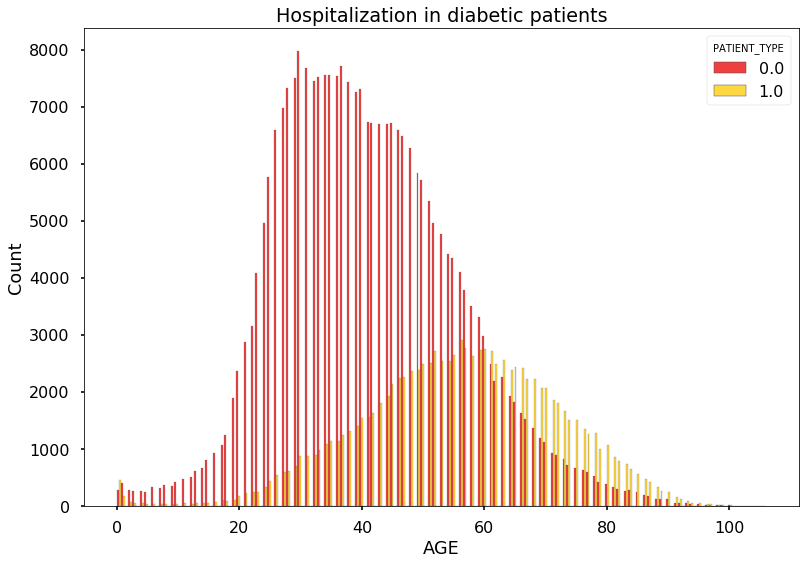

In [171]:
f, ax = plt.subplots()
sns.histplot(df,
    x='AGE', 
    hue="PATIENT_TYPE",
    palette='hot',
    edgecolor=".3",
    multiple="dodge",
)
ax.set_title('Hospitalization in diabetic patients')
;

''

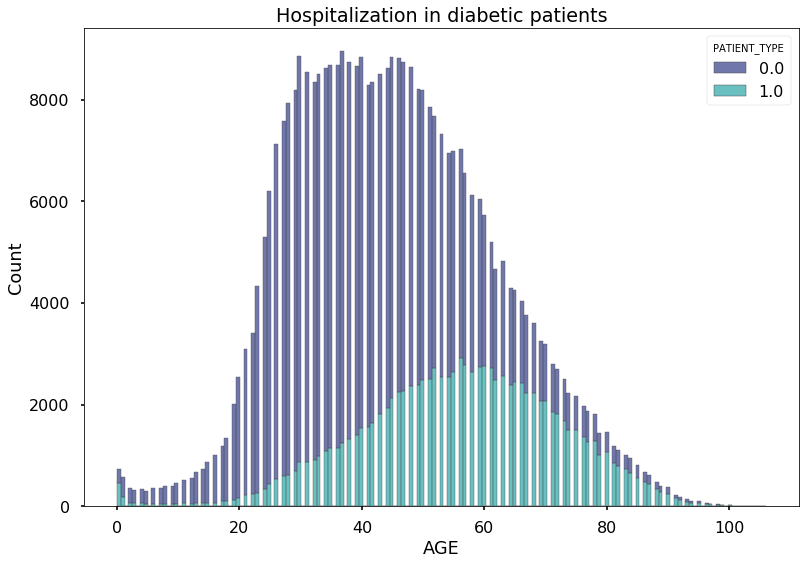

In [172]:
f, ax = plt.subplots()
sns.histplot(df,
    x='AGE', 
    hue="PATIENT_TYPE",
    palette='mako',
    edgecolor=".3",
    multiple="stack",
)
ax.set_title('Hospitalization in diabetic patients')
;

In [173]:
df['AGE_bins']=df['AGE']
bins = [0, 10 , 20 , 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-10','10-20', '20-30','30-40','40-50','50-60','60-70', '70-80', '80-90', '90-100', '100-110']
df['AGE_bins'] = pd.cut(df['AGE'], bins=bins, labels=labels)

''

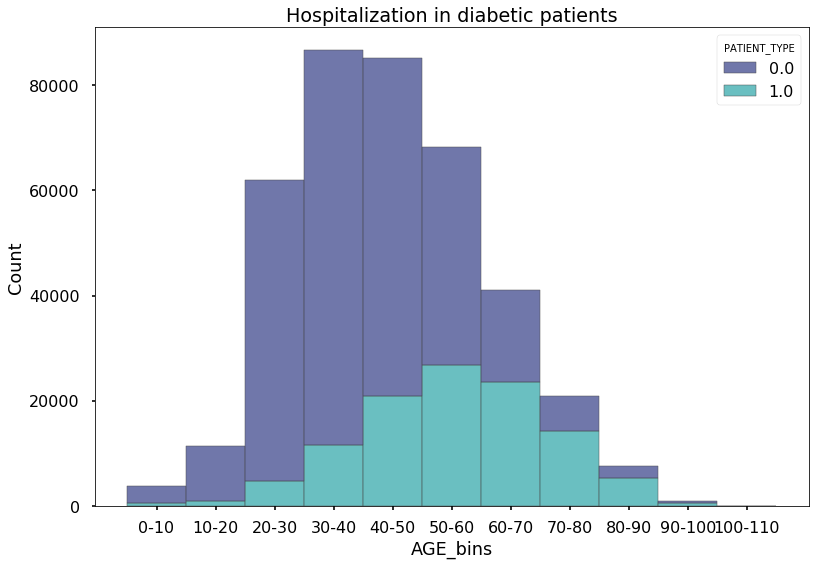

In [174]:
f, ax = plt.subplots()
sns.histplot(df,
    x='AGE_bins', 
    hue="PATIENT_TYPE",
    palette='mako',
    edgecolor=".3",
    multiple="stack",
    binwidth=1
)
ax.set_title('Hospitalization in diabetic patients')
;

In [175]:
df.loc[df["AGE_bins"]=='50-60']['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.608165
1.0    0.391835
Name: PATIENT_TYPE, dtype: float64

In [176]:
df.loc[df["AGE_bins"]=='20-30']['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.92246
1.0    0.07754
Name: PATIENT_TYPE, dtype: float64

In [177]:
df.loc[df["AGE"]==0]['PATIENT_TYPE'].value_counts(normalize=True)

1.0    0.610284
0.0    0.389716
Name: PATIENT_TYPE, dtype: float64

In [178]:
df.loc[df["AGE"]==2]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.810056
1.0    0.189944
Name: PATIENT_TYPE, dtype: float64

### Diabetes

Calculating the percentage of patients that had diabetes, whether they where hospitalized or not.

In [179]:
df.loc[df["DIABETES"]==1]['PATIENT_TYPE'].value_counts(normalize=True)

1.0    0.559976
0.0    0.440024
Name: PATIENT_TYPE, dtype: float64

Calculating the percentage of patients that did not have diabetes, whether they where hospitalized or not.

In [180]:
df.loc[df["DIABETES"]==0]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.770055
1.0    0.229945
Name: PATIENT_TYPE, dtype: float64

''

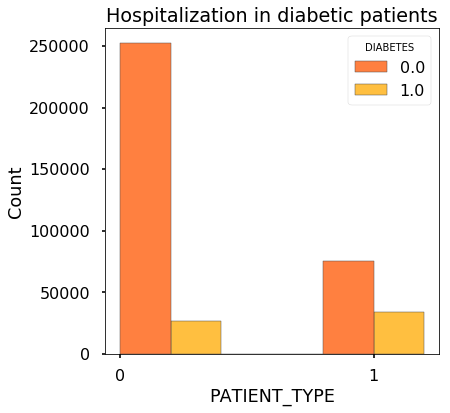

In [181]:
f, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df,
    x='PATIENT_TYPE', 
    hue="DIABETES",
    palette='autumn',
    edgecolor=".3",
    multiple="dodge",
    binwidth=0.4
)
ax.set_xticks([0,1])
ax.set_title('Hospitalization in diabetic patients')
;

### Hipertension

Calculating the percentage of patient with Hipertension that were hospitalized.

In [182]:
df.loc[df["HIPERTENSION"]==1]['PATIENT_TYPE'].value_counts(normalize=True)

1.0    0.509645
0.0    0.490355
Name: PATIENT_TYPE, dtype: float64

Calculating the percentage of patient without Hipertension that were hospitalized.

In [183]:
df.loc[df["HIPERTENSION"]==0]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.773146
1.0    0.226854
Name: PATIENT_TYPE, dtype: float64

''

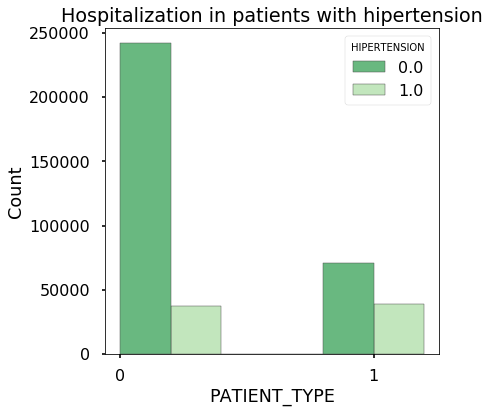

In [184]:
f, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df,
    x='PATIENT_TYPE', 
    hue="HIPERTENSION",
    palette='Greens_r',
    edgecolor=".3",
    multiple="dodge",
    binwidth=0.4
)
ax.set_xticks([0,1])
ax.set_title('Hospitalization in patients with hipertension')
;

### Sex

Studying the difference in hospitalization rate based on sex.
<br>For females:

In [185]:
df.loc[df["SEX"]==1]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.768165
1.0    0.231835
Name: PATIENT_TYPE, dtype: float64

Percentage of hospitalization in males:

In [186]:
df.loc[df["SEX"]==0]['PATIENT_TYPE'].value_counts(normalize=True)

0.0    0.673682
1.0    0.326318
Name: PATIENT_TYPE, dtype: float64

''

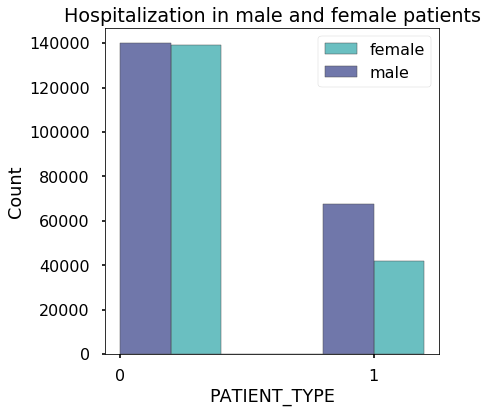

In [187]:
f, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df,
    x='PATIENT_TYPE', 
    hue="SEX",
    palette='mako',
    edgecolor=".3",
    multiple="dodge",
    binwidth=0.4
)
ax.set_xticks([0,1])
ax.set_title('Hospitalization in male and female patients')
ax.legend(labels=('female', 'male'))
;